In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from bio_embeddings.embed import SeqVecEmbedder
from Bio import SeqIO
%matplotlib inline

In [2]:
# Read the sequences from the sample fasta file
sequences = []
for record in SeqIO.parse("tiny_sampled.fasta", "fasta"):
    sequences.append((record.id, record.seq))

In [3]:
# generate the embeddings; will not take too long for 11 sequences
embedder = SeqVecEmbedder.with_download()
embeddings = []
for seq in tqdm.tqdm(sequences):
    embedding = embedder.embed(seq[1])
    # embeddings of the form 1024xLx3 with L being the sequence length
    emb = np.array(embedding)
    embeddings.append((seq[0], emb))


Downloaded files for ELMO v1 embedder
CUDA NOT available


100%|██████████| 11/11 [00:44<00:00,  4.06s/it]


In [4]:
# Normalize images
min_vals = np.array([255,255,255])
max_vals = np.array([0,0,0])

# Determine the normalization factctor for each embedding
for emb in embeddings:
    tmp_max = emb[1].max(axis = (1,2))
    max_vals = np.maximum(max_vals, tmp_max)
    tmp_min = emb[1].min(axis = (1,2))
    min_vals = np.minimum(min_vals, tmp_min)

dif = max_vals - min_vals

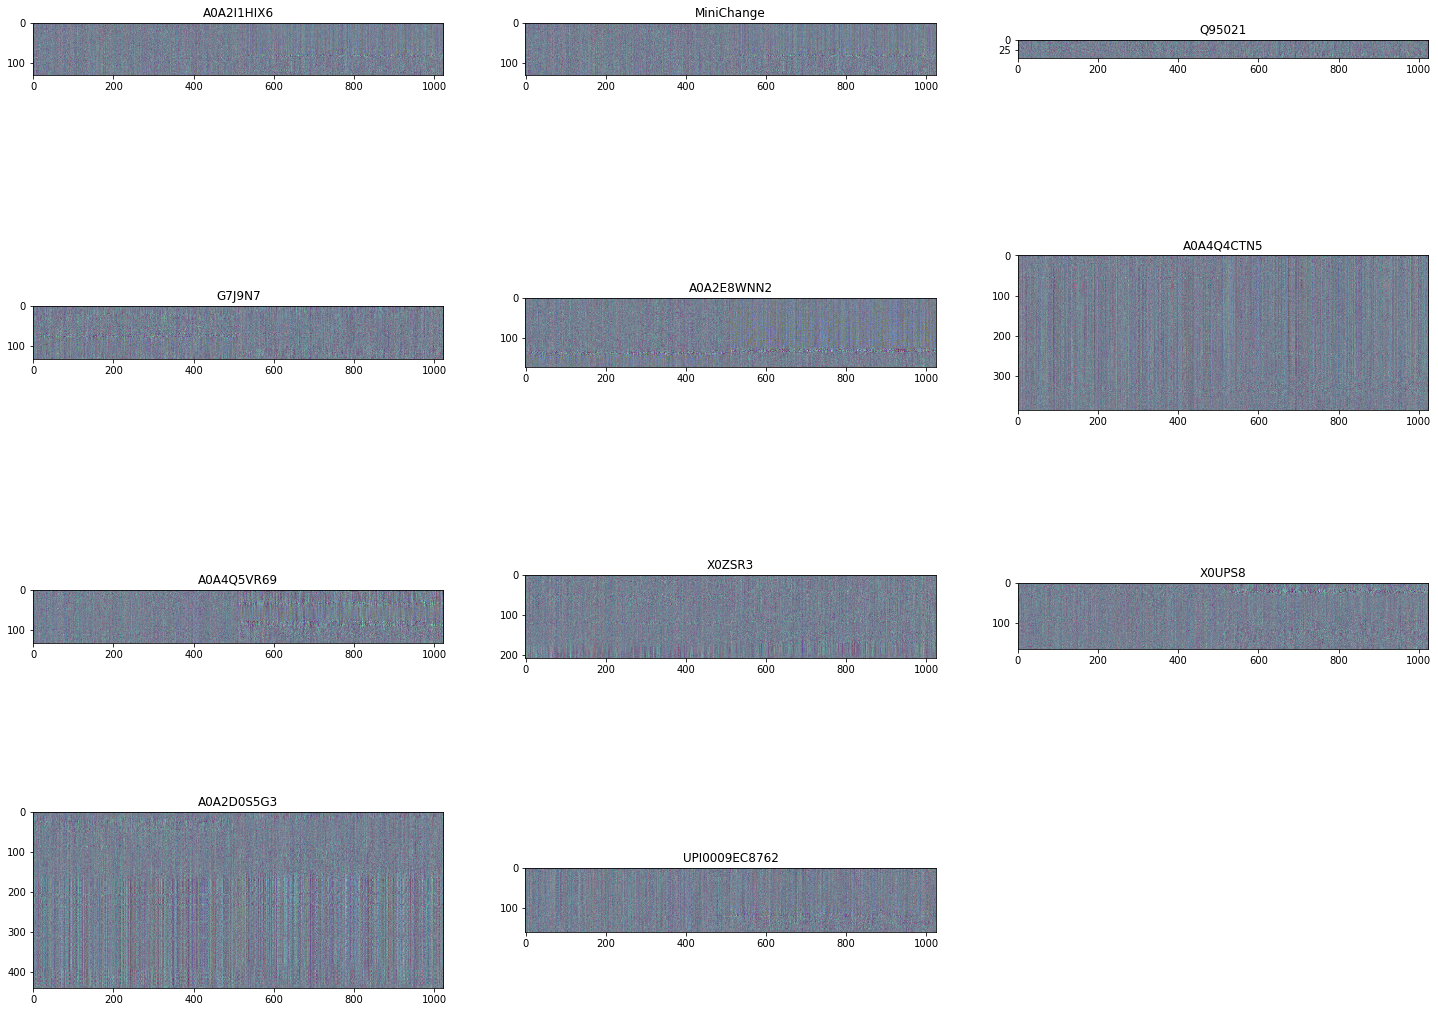

In [5]:
COLS = 3
ROWS = np.ceil(len(embeddings) / COLS)
IGNORE_FIRST = False # If true the first (uncontextualized) layer is zerod out

# SHow the ELMO embeddings as RGB images
fig = plt.figure(figsize=(25,20))
for idx, emb in enumerate(embeddings):
    data = emb[1]
    data = np.rollaxis(data, 0, 3)
    data = (data - min_vals) / dif
    if IGNORE_FIRST:
        data[:,:,0] = 0
    ax = fig.add_subplot(ROWS, COLS, idx+1)
    ax.set_title(emb[0])
    ax.imshow(data)

plt.show()

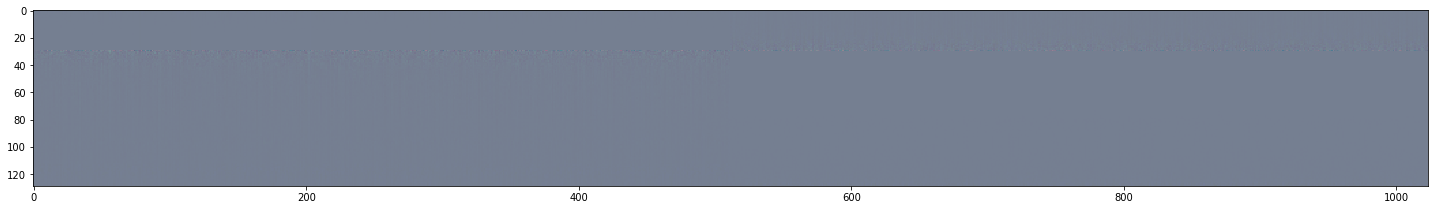

In [6]:
# The first and the second protein sequences are nearly the same with one mutation.
# Visualize the difference in their ELMO embeddings
data = embeddings[0][1] - embeddings[1][1]
data = np.rollaxis(data, 0, 3)
data = (data - min_vals) / dif
fig = plt.figure(figsize=(25,20))


ax = fig.add_subplot(1, 1, 1)
ax.imshow(data)

plt.show()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


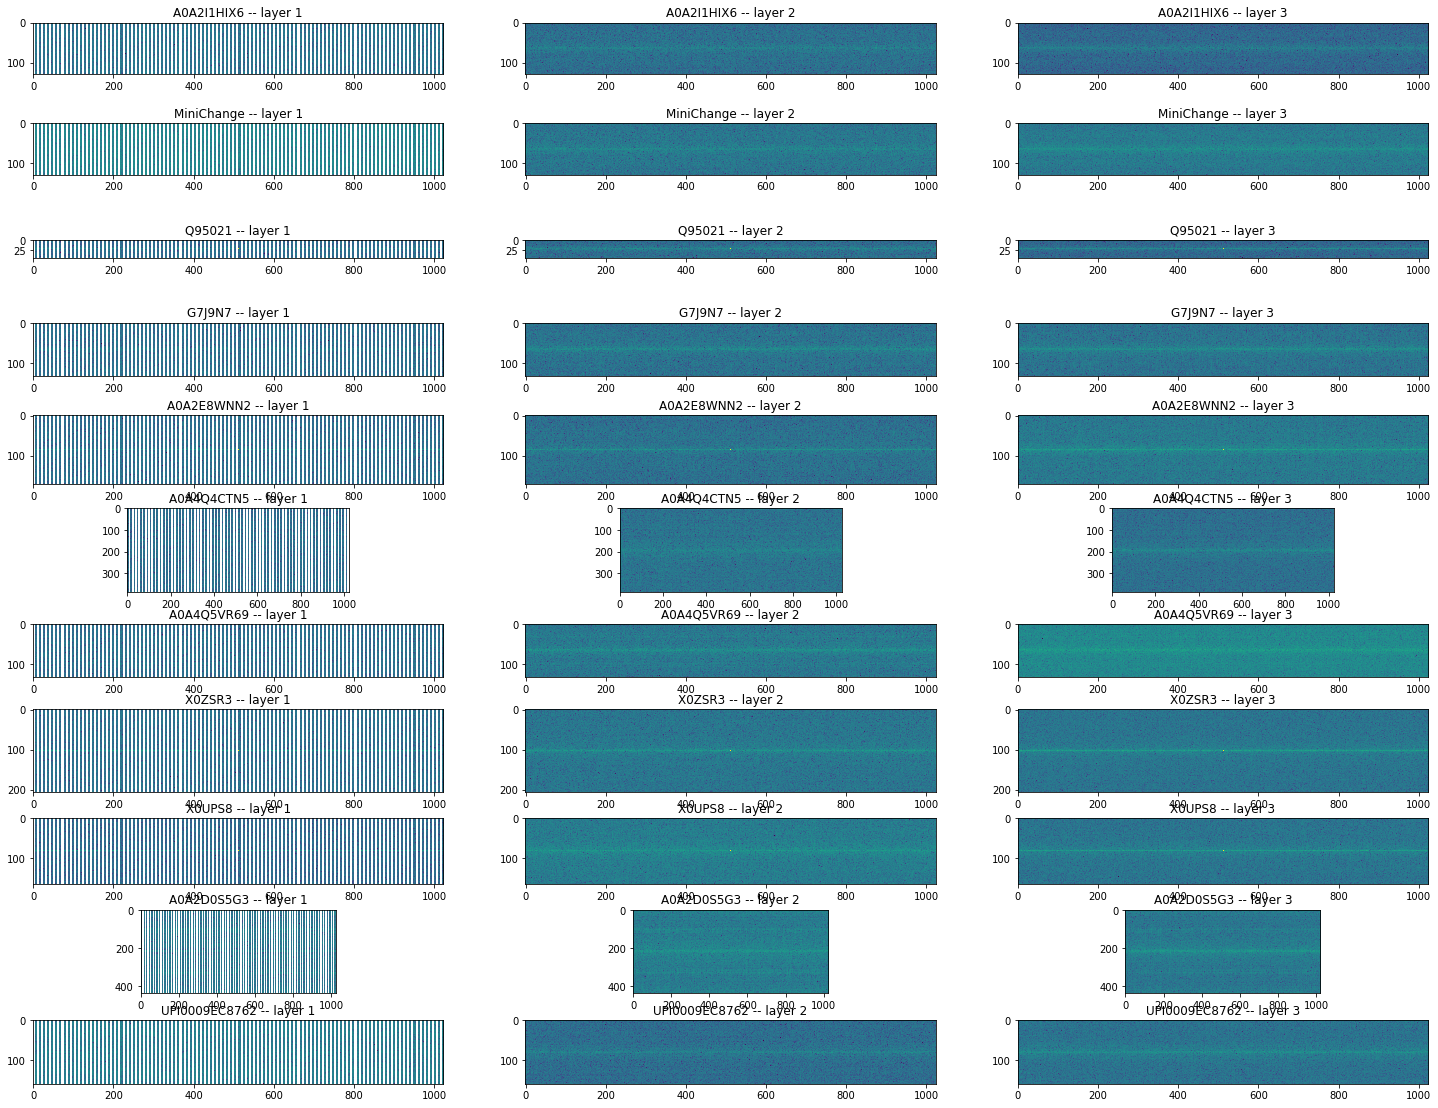

In [7]:
# Fourier Transform the created images
from scipy import fftpack
COLS = 3
ROWS = np.ceil(len(embeddings)*3 / COLS)
IGNORE_FIRST = False

fig = plt.figure(figsize=(25,20))
idx = 0
for emb in embeddings:
    data = emb[1]
    data = np.rollaxis(data, 0, 3)
    data = (data - min_vals) / dif
    if IGNORE_FIRST:
        data[:,:,0] = 0

    F1 = fftpack.fft2(data[:,:,0])
    F2 = fftpack.fft2(data[:,:,1])
    F3 = fftpack.fft2(data[:,:,2])
    # Now shift so that low spatial frequencies are in the center.
    F1 = np.log(np.abs(fftpack.fftshift( F1 )))
    F2 = np.log(np.abs(fftpack.fftshift( F2 )))
    F3 = np.log(np.abs(fftpack.fftshift( F3 )))

    ax = fig.add_subplot(ROWS, COLS, idx+1)
    ax.set_title(f"{emb[0]} -- layer 1")
    ax.imshow(F1)
    ax = fig.add_subplot(ROWS, COLS, idx+2)
    ax.set_title(f"{emb[0]} -- layer 2")
    ax.imshow(F2)
    ax = fig.add_subplot(ROWS, COLS, idx+3)
    ax.set_title(f"{emb[0]} -- layer 3")
    ax.imshow(F3)
    idx = idx+3

plt.show()